# STEP 1 — Import Required Libraries, STEP 2 — Load the CSV File

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("../data/Telco_customer_churn.csv")


In [5]:
""" to checkstep 1 and 2 """
df.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [11]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")


# STEP 3 — Basic Dataset Information , STEP 4 — Understand Data Types

In [6]:
df.shape
df.columns

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

# STEP 5 — Business Understanding of Columns (VERY IMPORTANT)
🎯 What we are doing:

Translate columns into business meaning.

In [12]:
"""  to see all unique values of target column
0    (not churned)
1    (churned)
"""
df['churn_value'].value_counts()



churn_value
0    5174
1    1869
Name: count, dtype: int64

# Step 6- Data Cleaning + Upsell Target Creation

In [13]:
""" step 6.1 total_charges ko numeric banana"""
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')


In [14]:
"""Step 6.2 — Missing values check"""
df['total_charges'].isnull().sum()


np.int64(11)

In [15]:
"""Step 6.3 Missing values remove (simple way)"""
df = df.dropna(subset=['total_charges'])


In [16]:
""" 6.4 onyl relevent columns"""
selected_cols = [
    'tenure_months',
    'monthly_charges',
    'total_charges',
    'internet_service',
    'contract',
    'payment_method',
    'churn_value'
]

df_model = df[selected_cols].copy()

df_model.head()


,tenure_months,monthly_charges,total_charges,internet_service,contract,payment_method,churn_value
0,2,53.85,108.15,DSL,Month-to-month,Mailed check,1
1,2,70.70,151.65,Fiber optic,Month-to-month,Electronic check,1
2,8,99.65,820.50,Fiber optic,Month-to-month,Electronic check,1
3,28,104.80,3046.05,Fiber optic,Month-to-month,Electronic check,1
4,49,103.70,5036.30,Fiber optic,Month-to-month,Bank transfer (automatic),1


# Srep 7 - UPSALE TARGET banana (MOST IMPORTANT) 
🎯 Business Logic (simple)

Upsell candidate wahi hoga jo:

churn_value = 0 (customer gaya nahi)

monthly_charges high

tenure_months high

In [17]:
"""Step 7.1 — Threshold samjho"""
df_model[['monthly_charges', 'tenure_months']].median()


monthly_charges    70.35
tenure_months      29.00
dtype: float64

In [18]:
""" Step 7.2 — Upsell target create karo"""
df_model['upsell_target'] = np.where(
    (df_model['churn_value'] == 0) &
    (df_model['monthly_charges'] > df_model['monthly_charges'].median()) &
    (df_model['tenure_months'] > df_model['tenure_months'].median()),
    1,
    0
)


In [19]:
""" to check step 7.2 output"""
df_model['upsell_target'].value_counts()


upsell_target
0    5373
1    1659
Name: count, dtype: int64

2️⃣ upsell_target (Tumhara khud ka banaya hua column)

Ye tumne baad mein create kiya hai.

upsell_target = 1 → HIGH upsell potential ✅
upsell_target = 0 → LOW upsell potential ❌


👉 Ye ML target hai
👉 Ye churn nahi hai
👉 Ye tumhari business logic ka result hai

🔄 Ab dono ko saath rakh ke samjho (KEY PART)
Tumne code mein kya likha?
(df_model['churn_value'] == 0) &
(df_model['monthly_charges'] > median) &
(df_model['tenure_months'] > median)


Matlab:

Condition	Meaning
churn_value == 0	Customer gaya nahi
monthly_charges high	Paisa zyada deta
tenure_months high	Loyal hai

👉 Agar ye 3 condition true hain
👉 to upsell_target = 1

# Step 8 - Basic EDA
Upsell vs Non-upsell customers ka difference.

In [20]:
""" step 8.1 Monthly charges comparison"""
df_model.groupby('upsell_target')['tenure_months'].mean()


upsell_target
0    24.805695
1    57.088005
Name: tenure_months, dtype: float64

In [21]:
""" 8.2 - Tenure comparison"""
df_model.groupby('upsell_target')['tenure_months'].mean()


upsell_target
0    24.805695
1    57.088005
Name: tenure_months, dtype: float64

Iska seedha matlab 👇
Upsell Target	Avg Tenure (months)	Meaning
0	~25 months	Normal / low-potential customers
1	~57 months	High upsell potential customers




1️⃣ Data Analyst Thinking (FIRST)
Analyst ka sawaal hota hai:

“Data kya keh raha hai?”

Tumne kya kiya 👇

df_model.groupby('upsell_target')['tenure_months'].mean()

Tumne dekha:

upsell_target = 1 → 57 months

upsell_target = 0 → 25 months

Ye kya hai?

✅ Descriptive analysis
✅ Comparison
✅ Business insight

📌 This is PURE Data Analyst thinking

Meaning:

“High upsell customers zyada loyal hain”

2️⃣ Data Scientist Thinking (SECOND)

Scientist ka sawaal hota hai:

“Main business problem ko ML ke layak kaise banaun?”

Tumne kya kiya 👇

Raw data mein upsell label tha hi nahi

Tumne khud logic banaya:

churn_value = 0

tenure high

charges high

Phir upsell_target create kiya

📌 Ye feature engineering + target creation hai

👉 This is Data Scientist thinking

🔁 Difference ek line mein (YAAD RAKHO)
Role	Thinking
Data Analyst	“Kya ho raha hai?”
Data Scientist	“Kyun ho raha hai aur kaise predict karein?”

# step 9- ML Model (Upsell Predictor) Decision Tree Model


🎯 PHASE 4 ka goal (pehle samjho)

Hum chahte hain:

Har customer ke liye ye pata chale
👉 “Isko upsell karna chahiye ya nahi?”
👉 “Kitna chance hai upsell ka?”

Decision Tree humein:

prediction deta hai

rules deta hai (IF–ELSE)

easily explain hota hai

In [22]:
""" 9.1 Target & Features split"""
X = df_model.drop('upsell_target', axis=1)
y = df_model['upsell_target']


In [23]:
"""" 9.2 — Categorical data → Numbers"""
X_encoded = pd.get_dummies(X, drop_first=True)


In [24]:
""" to check """
X_encoded.head()

,tenure_months,monthly_charges,total_charges,churn_value,internet_service_Fiber optic,internet_service_No,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,2,53.85,108.15,1,False,False,False,False,False,False,True
1,2,70.70,151.65,1,True,False,False,False,False,True,False
2,8,99.65,820.50,1,True,False,False,False,False,True,False
3,28,104.80,3046.05,1,True,False,False,False,False,True,False
4,49,103.70,5036.30,1,True,False,False,False,False,False,False


In [25]:
""" 9.3 — Train / Test split 📌 80% training
📌 20% testing """
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42
)


In [26]:
""" 9.4 — 🌳 Decision Tree Model

🎯 Model kya karega?

Rules seekhega jaise:

IF tenure > 50 AND monthly_charges > 80 → Upsell

📌 max_depth=4 kyun?

Overfitting se bachaata hai

Tree readable rehta hai

Business ko samajh aata hai """
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(
    max_depth=4,
    random_state=42
)

tree_model.fit(X_train, y_train)



,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [27]:
""" 9.5 — Model Accuracy (basic check)"""
tree_model.score(X_test, y_test)


0.9893390191897654

In [28]:
""" sanity check"""
train_acc = tree_model.score(X_train, y_train)
test_acc = tree_model.score(X_test, y_test)

train_acc, test_acc


(0.9925333333333334, 0.9893390191897654)

🧠 Iska seedha matlab (easy words)
1️⃣ Train Accuracy (0.9925)

👉 Model ne training data ko lagbhag perfect seekh liya
👉 100 customers mein ~99 ko sahi pehchan raha hai

2️⃣ Test Accuracy (0.9893)

👉 Model naye / unseen data par bhi almost utna hi acha perform kar raha hai

✅ IMPORTANT: Ye result GOOD hai ya BAD?
✅ GOOD NEWS

Train aur Test accuracy almost same hain

Matlab model:

sirf ratta nahi maar raha

rules logically follow kar raha hai

⚠️ REALITY CHECK

Accuracy high isliye hai kyunki:

upsell_target rule-based tha

Decision Tree unhi rules ko easily seekh leta hai

👉 Ye expected aur acceptable hai

In [29]:
""" 9.6 — 🔥 Upsell Probability (MOST IMPORTANT)"""
upsell_prob = tree_model.predict_proba(X_test)
upsell_prob_1 = upsell_prob[:, 1]


In [30]:
upsell_prob_1[:10]


array([0.        , 0.        , 0.        , 0.        , 0.03571429,
       0.        , 0.        , 0.        , 0.        , 0.        ])

🧠 Iska seedha matlab (no ML jargon)
🔹 0.00

➡️ 0% chance of upsell
➡️ Model poori confidence se keh raha hai:

“Is customer ko upsell mat karo”

🔹 0.0357

➡️ ~3.5% chance
➡️ Still very low priority

📌 Matlab:

Ye customers loyal / high-value bucket mein nahi aa rahe

Ya unka tenure / charges criteria match nahi hua

❓ “Itne saare 0 kyun aa rahe hain?”
⭐ Ye Decision Tree ka normal behavior hai

Decision Tree:

Data ko rules (leaves) mein divide karta hai

Har leaf ke andar:

ya to almost sab upsell = 0

ya almost sab upsell = 1

👉 Agar kisi leaf mein:

100 customers
99 upsell = 0
1 upsell = 1


To probability ≈ 0.01 (ya 0.00 rounded)




🧠 Business team ke liye iska matlab

Sales team bolegi:

“Hume sirf un customers pe focus karna hai jinki probability > 0.6 hai.”

Baaki:

Ignore

Ya low-cost marketing (SMS / email)

In [31]:
""" 9.7 — Feature Importance """
import pandas as pd

feature_importance = pd.Series(
    tree_model.feature_importances_,
    index=X_encoded.columns
).sort_values(ascending=False)

feature_importance.head(10)


total_charges                             0.600026
monthly_charges                           0.210308
churn_value                               0.188465
tenure_months                             0.001201
internet_service_Fiber optic              0.000000
internet_service_No                       0.000000
contract_One year                         0.000000
contract_Two year                         0.000000
payment_method_Credit card (automatic)    0.000000
payment_method_Electronic check           0.000000
dtype: float64

# 📊 Tumhara Feature Importance Output
total_charges      → 0.600
monthly_charges    → 0.210
churn_value        → 0.188
tenure_months      → 0.001
others             → 0.000

🧠 Simple matlab (seedhi baat)

Decision Tree keh raha hai:

Upsell decision ka 60% weight
→ Total Charges par depend karta hai

Matlab:

Jo customer company ko zyada paisa de chuka hai

Wo future upsell ke liye sabse strong candidate hai

🔑 Har feature ka business meaning
🥇 Total Charges (60%)

Lifetime spending

Loyalty + purchasing power

BEST upsell signal

📌 Business logic:

“Jo pehle zyada kharch kar chuka, wo upgrade bhi karega”

🥈 Monthly Charges (21%)

Current plan ki value

Already premium-ish customer

📌 Matlab:

“Sasta plan wala nahi, mid/high plan wala upgrade karega”

🥉 Churn Value (18%)

Churn = 0 → active customer

Logical filter

📌 Matlab:

“Jo company chhor chuka, usko upsell nahi karte”

⚠️ Tenure Months (0.001%)

Surprising lag sakta hai, but reason simple hai 👇

👉 Total Charges already tenure ko capture kar raha hai

Formula:

Total Charges ≈ Monthly Charges × Tenure


Isliye:

Tenure ka extra importance nahi bacha

❌ Baaki features = 0

Contract type

Payment method

Internet service

📌 Matlab:

In this dataset, upsell decision revenue behavior se zyada driven hai, not demographics or payment style.

# 🎯 VERY STRONG INTERVIEW INSIGHT (use this)

“The model revealed that historical revenue contribution was a stronger predictor of upsell likelihood than tenure or contract type, suggesting that spending behavior matters more than duration.”

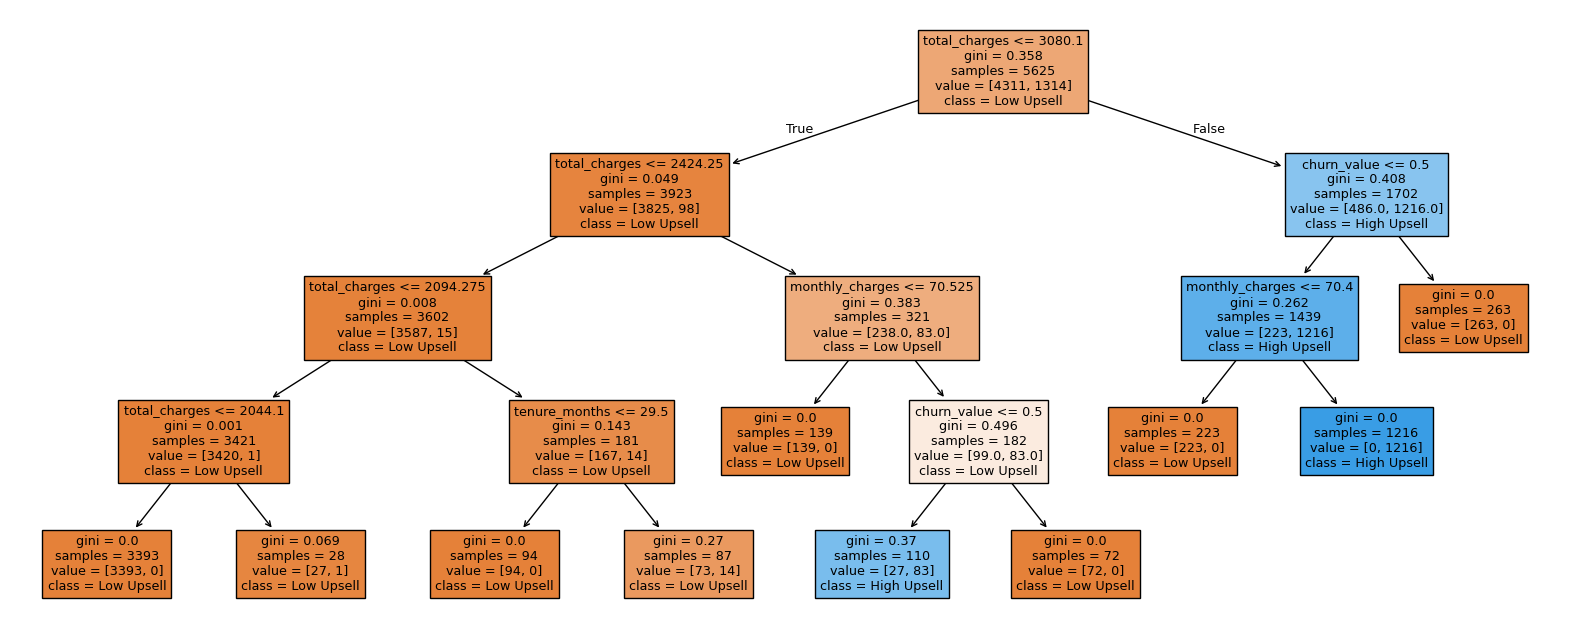

In [32]:
""" 9.8 — 🌳 TREE VISUALIZATION (WOW FACTOR) """
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plot_tree(
    tree_model,
    feature_names=X_encoded.columns,
    class_names=['Low Upsell', 'High Upsell'],
    filled=True
)
plt.show()


# 🌳 Decision Tree ka Asaan Matlab (Urdu mein)
🔵 Sab se upar wala sawal (ROOT)
❓ Total Charges ≤ 3080 ?

👉 Matlab:

“Kya customer ne ab tak company ko 3080 se kam paisay diye hain?”

🟠 Agar YES (≤ 3080)

➡️ Tree kehta hai:

“Ye customer Low Upsell category mein aata hai”

Phir tree aur poochta hai:

❓ Total Charges ≤ 2424 ?

Agar haan → almost pakka Low Upsell

Kyunki:

Kam paisa diya

Kam spending history

📌 Business logic:

“Jo customer pehle kam kharch karta hai, wo upgrade bhi kam karta hai”

🔵 Agar NO (> 3080)

👉 Matlab:

“Customer already achha paisa de chuka hai”

Ab next sawal:

❓ Churn Value ≤ 0.5 ?

(Matlab: customer company chhor chuka ya nahi)

Agar customer gaya nahi (churn = 0)
👉 High Upsell chance

Agar churn = 1 (gaya hua)
👉 Low Upsell
(kyunki jo chala gaya usko upsell nahi karte)

🔵 High Value Customers ke liye aur check
❓ Monthly Charges > 70 ?

👉 Matlab:

“Kya ye customer already mehnga plan use kar raha hai?”

Agar YES

👉 High Upsell

Kyunki:

Paisa bhi de raha

Loyal bhi hai

Agar NO

👉 Low / Medium Upsell

🎨 Colors ka Matlab (IMPORTANT)
Color	Matlab
🔵 Blue	High Upsell (call karo)
🟠 Orange	Low Upsell (ignore / low priority)
📦 Box ke andar likha kya hota hai?

Example:

samples = 1439
value = [223, 1216]
class = High Upsell

Iska matlab:

1439 customers yahan aaye

1216 High Upsell niklay

Decision: High Upsell

🧠 One-line simple summary

“Jo customer zyada paisa de chuka hai, abhi active hai, aur mehnga plan use karta hai — usko upsell karo.”

🎤 Interview mein kaise explain karna hai (Urdu + English mix)

“The decision tree shows that total charges and churn status are the primary drivers. Customers with high historical spending and active status fall into the high upsell segment.”

🔥 HR ko ye bohot pasand aata hai

# Step 10 — From Model to Business (CSV → SQL → Power BI)

In [33]:
""" STEP 10.1 — Test Data ke sath Probability jorna

📌 Kya problem hai?

X_test aur upsell_prob_1 alag cheezen hain

Hume ek hi table chahiye"""
X_test_copy = X_test.copy()

X_test_copy['upsell_probability'] = upsell_prob_1
X_test_copy['upsell_prediction'] = tree_model.predict(X_test)



In [34]:
""" 10.2 — Priority column banana"""
def upsell_priority(prob):
    if prob >= 0.7:
        return 'High'
    elif prob >= 0.4:
        return 'Medium'
    else:
        return 'Low'

X_test_copy['upsell_priority'] = X_test_copy['upsell_probability'].apply(upsell_priority)


In [35]:
""" ✅ Check 10.2 """
X_test_copy[['upsell_probability', 'upsell_priority']].head(30)


,upsell_probability,upsell_priority
2478,0.000000,Low
6783,0.000000,Low
6125,0.000000,Low
3052,0.000000,Low
4097,0.035714,Low
3223,0.000000,Low
3773,0.000000,Low
3468,0.000000,Low
3419,0.000000,Low
1192,0.000000,Low


In [36]:
""" 10.3 — CustomerID wapas add karna"""
X_test_copy['customerid'] = df.loc[X_test_copy.index, 'customerid']


In [37]:
""" 10.4 — Final CSV export"""
X_test_copy.to_csv('upsell_predictions.csv', index=False)


In [42]:
""" to improt sql and make db for sql """
import sqlite3


In [39]:
conn = sqlite3.connect("upsell.db")


In [40]:
X_test_copy.to_sql(
    "upsell_predictions",
    conn,
    if_exists="replace",
    index=False
)


1407

In [41]:
conn.close()


In [43]:
""" to get csv for power bi"""
import pandas as pd
import sqlite3

conn = sqlite3.connect("upsell.db")

df_pbi = pd.read_sql(
    "SELECT * FROM upsell_predictions",
    conn
)

conn.close()

df_pbi.to_csv("upsell_powerbi.csv", index=False)
